In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
movies_filename = 'dataset/movie.csv'
ratings_filename = 'dataset/rating.csv'

In [7]:
df_movies = pd.read_csv(
    movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [10]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 138493 unique users and 26744 unique movies in this data set


In [11]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [12]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,3683856529
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [13]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,3683856529,22.027226
0.5,239125,12.384742
1.0,680732,13.430924
1.5,279252,12.539870
2.0,1430997,14.173882
2.5,883398,13.691531
3.0,4291193,15.272075
3.5,2200156,14.604039
4.0,5561926,15.531455
4.5,1534824,14.243926


Text(0, 0.5, 'number of ratings')

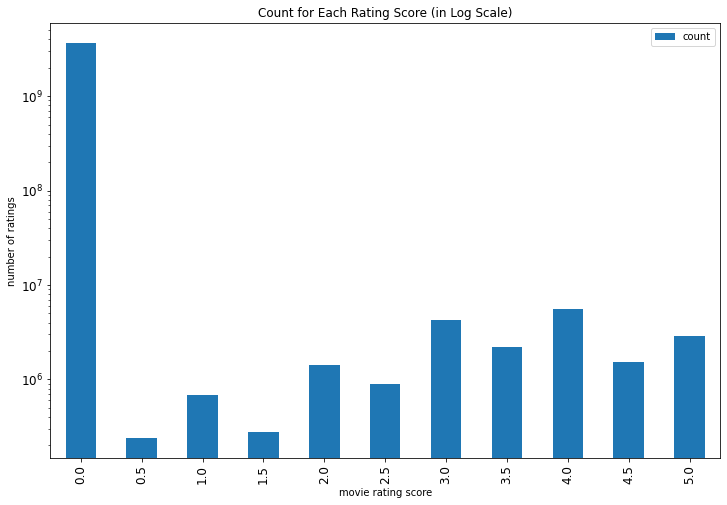

In [14]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [18]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
Name: count, dtype: float64

In [20]:
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping unpopular movies:  (19847947, 3)


In [21]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,174
2,61
3,187
4,28
5,66


In [22]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    6769.0
0.95     518.0
0.90     333.0
0.85     246.0
0.80     192.0
0.75     154.0
0.70     127.0
0.65     107.0
0.60      92.0
0.55      78.0
Name: count, dtype: float64

In [23]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (18181935, 3)


In [24]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [25]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [26]:
movie_user_mat_sparse

<10524x85194 sparse matrix of type '<class 'numpy.float32'>'
	with 18181935 stored elements in Compressed Sparse Row format>

In [30]:
model_knn.kneighbors_graph()

<10524x10524 sparse matrix of type '<class 'numpy.float64'>'
	with 210480 stored elements in Compressed Sparse Row format>

In [32]:
model_knn.kneighbors(movie_user_mat_sparse)

(array([[1.4066696e-04, 3.7505895e-01, 3.7584144e-01, ..., 4.2935163e-01,
         4.3125325e-01, 4.3778449e-01],
        [1.0597706e-04, 4.3891627e-01, 4.5023990e-01, ..., 5.1473916e-01,
         5.1717401e-01, 5.1974654e-01],
        [6.7949295e-06, 5.6899947e-01, 6.0527015e-01, ..., 6.5401804e-01,
         6.5539616e-01, 6.5559065e-01],
        ...,
        [0.0000000e+00, 8.1380022e-01, 8.2059979e-01, ..., 8.6407328e-01,
         8.6727303e-01, 8.7036777e-01],
        [0.0000000e+00, 7.3899007e-01, 7.4263656e-01, ..., 8.3132309e-01,
         8.3191276e-01, 8.3193767e-01],
        [1.1920929e-07, 8.3804417e-01, 8.5409647e-01, ..., 8.8326573e-01,
         8.8423234e-01, 8.8723379e-01]], dtype=float32),
 array([[    0,   340,   246, ...,   558,   561,  3818],
        [    1,   351,   348, ...,   328,   556,   702],
        [    2,     4,   710, ...,   516,   556,   352],
        ...,
        [10521, 10468, 10509, ..., 10255, 10415, 10482],
        [10522, 10128, 10445, ..., 10383, 102

In [51]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    if(not idx):
        return
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [55]:
my_favorite = 'Matrix 1999'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Matrix 1999
Found possible matches in our database: ['Matrix, The (1999)', 'Trick (1999)', 'Simpatico (1999)', 'Human Traffic (1999)', 'Matinee (1993)', 'Bats (1999)', 'Matilda (1996)', 'Amateur (1994)', 'Masterminds (1997)', 'Santitos (1999)', 'Magnolia (1999)', 'Stigmata (1999)', 'Maverick (1994)', 'Titus (1999)', 'Dogma (1999)', 'Metro (1997)']

Recommendation system start to make inference
......

Recommendations for Matrix 1999:
1: American Beauty (1999), with distance of 0.3337617516517639
2: Saving Private Ryan (1998), with distance of 0.33242690563201904
3: Star Wars: Episode IV - A New Hope (1977), with distance of 0.3295525908470154
4: Gladiator (2000), with distance of 0.3290725350379944
5: Lord of the Rings: The Two Towers, The (2002), with distance of 0.3228139877319336
6: Men in Black (a.k.a. MIB) (1997), with distance of 0.31868743896484375
7: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.2998355031013489
8: Sixth Sense, 